In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/speech-emotion-dataset/features.csv


## Importing required libraries

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

## Data path

In [3]:
csv = '../input/speech-emotion-dataset/features.csv'
Features = pd.read_csv(csv)

## Looking into the data

In [4]:
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-637.701233,104.299019,4.894947,20.494011,12.552954,2.851410,-6.633390,-4.091278,-10.423918,-6.406950,...,0.172893,-1.170210,-5.292450,-0.573319,1.019471,-3.492607,-3.468123,-1.214944,1.971239,male_calm
1,-596.908460,86.871936,9.470162,17.109819,11.198966,1.541056,-6.677264,-5.755428,-9.684472,-6.891256,...,0.033803,-1.986515,-5.103855,-1.253110,0.514896,-3.268317,-4.502895,0.167153,0.256732,male_calm
2,-698.086548,99.795929,1.892679,19.915264,7.532868,1.265761,-9.188656,-5.798194,-12.299710,-4.976400,...,-1.639542,-2.603761,-4.890347,-0.879222,-1.250208,-3.449960,-4.708529,-0.086224,-3.034044,male_calm
3,-279.141052,41.092949,-21.319229,7.802911,-13.140503,-9.407660,-15.580647,-6.097223,-24.700903,-9.640293,...,-10.305976,-4.092835,-5.817179,-10.731523,-0.823596,-15.885103,-2.014258,-6.173852,-5.331760,male_angry
4,-160.074686,17.576058,-2.147436,3.133417,-4.745002,-6.510771,-5.911591,-4.481506,-9.470598,-5.907823,...,-4.088007,-1.817639,-2.994765,-4.893176,-2.880436,-7.163400,-2.147345,-2.359248,-3.746217,male_angry


**0 - 19 columns are the extracted features and can be trained to get the desired emotion.**

## One Hot Encoding and Scaling the data

In [5]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=24, shuffle=True)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 20, 1), (3240, 16), (1080, 20, 1), (1080, 16))

## Model building

In [6]:
# model=Sequential()
# model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

# model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

# model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# model.add(Dropout(0.2))

# model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

# model.add(Flatten())
# model.add(Dense(units=32, activation='relu'))
# model.add(Dropout(0.3))

# model.add(Dense(units=16, activation='softmax'))
# model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

# model.summary()


model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))

model.add(LSTM(128))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='softmax'))

optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 2048)          12288     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 2048)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 2048)          8192      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 1024)          10486784  
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 1024)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 1024)           4096      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 512)            2

## Callback

In [7]:
# rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
# history=model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp])

history = model.fit(x_train, y_train, batch_size=64, epochs=200, validation_data=(x_test, y_test))

Epoch 1/200
51/51 [==============================] - 12s 51ms/step - loss: 2.7597 - accuracy: 0.0778 - val_loss: 2.7660 - val_accuracy: 0.0991
Epoch 2/200
51/51 [==============================] - 1s 26ms/step - loss: 2.7180 - accuracy: 0.1125 - val_loss: 2.7581 - val_accuracy: 0.0833
Epoch 3/200
51/51 [==============================] - 1s 27ms/step - loss: 2.6875 - accuracy: 0.1278 - val_loss: 2.7530 - val_accuracy: 0.1231
Epoch 4/200
51/51 [==============================] - 1s 26ms/step - loss: 2.6225 - accuracy: 0.1504 - val_loss: 2.7485 - val_accuracy: 0.0731
Epoch 5/200
51/51 [==============================] - 1s 27ms/step - loss: 2.5874 - accuracy: 0.1613 - val_loss: 2.7461 - val_accuracy: 0.0787
Epoch 6/200
51/51 [==============================] - 1s 27ms/step - loss: 2.5418 - accuracy: 0.1785 - val_loss: 2.7402 - val_accuracy: 0.0611
Epoch 7/200
51/51 [==============================] - 1s 27ms/step - loss: 2.4169 - accuracy: 0.2262 - val_loss: 2.7187 - val_accuracy: 0.0713
Epoch

In [8]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

34/34 [==============================] - 0s 7ms/step - loss: 1.4374 - accuracy: 0.8139
Accuracy of our model on test data :  81.38889074325562 %


## Plotting train and test loss and accuracy

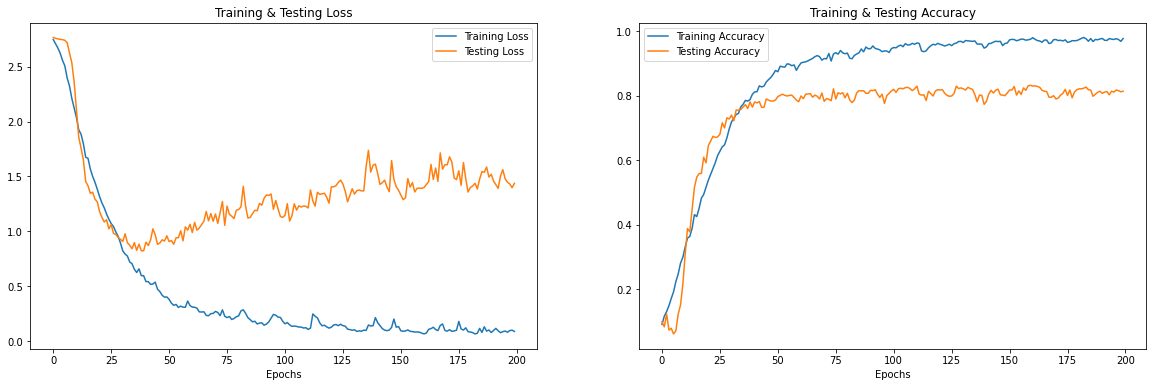

In [9]:
epochs = [i for i in range(200)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [10]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,female_fear,female_fear
1,female_calm,female_calm
2,male_fear,male_fear
3,female_surprise,female_surprise
4,female_surprise,female_happy
5,male_disgust,male_disgust
6,male_fear,male_fear
7,female_fear,female_fear
8,female_disgust,female_surprise
9,male_surprise,male_surprise


## Confusion Matrix

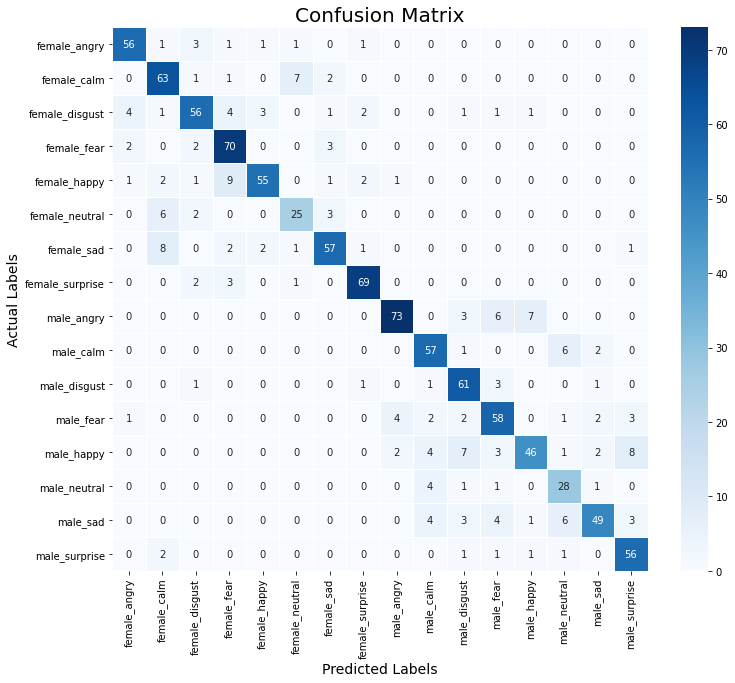

In [11]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [12]:
# model = Sequential()
# model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
# model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
# model.add(BatchNormalization())

# model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
# model.add(BatchNormalization())

# model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
# model.add(BatchNormalization())

# model.add(LSTM(128, return_sequences=True))

# model.add(LSTM(64))

# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))

# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.5))

# model.add(Dense(16, activation='softmax'))

# optimiser = keras.optimizers.Adam(learning_rate=0.0001)
# model.compile(optimizer=optimiser,
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

# model.summary()